## BBM 444 - Programming Assignment 1: Camera Pipeline

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

##  Emre Can Şahin , 2210356146




## 1. Implement a basic image processing pipeline (80 points)

### 1.1 Raw Image Conversion (5 points)

### LINK TO IMAGES
https://drive.google.com/drive/folders/1Wm83IRvwcAopb4_bZDx9p8bfsywmUErs?usp=sharing


In [77]:
## Initialize the variables obtained with "dcraw -4 -d -v -T <RAW_filename>"

black =0
white =4095

r_scale =2.629696
g_scale =1.000000
b_scale =1.251207

### 1.2. Python Initials (5 points)

In [33]:
## Import necessary libraries
import matplotlib.pyplot as plt
from skimage import io
import numpy as np 
from scipy.interpolate import interp2d, RegularGridInterpolator
import skimage.color as color
import skimage
import argparse
from skimage.color import rgb2gray


In [3]:
## Read the img and print (use skimage's imread function) how many bits per pixel the image has, its width, and its height.
## (See numpy functions shape, dtype and astype.)
image = io.imread('sample.tiff')
height, width = image.shape[:2]  
bits = image.dtype.itemsize * 8  # bpp
print(f"Image Width: {width} pixels")
print(f"Image Height: {height} pixels")
print(f"Bits per Pixel: {bits} bits")
print(image.dtype)

Image Width: 3039 pixels
Image Height: 2014 pixels
Bits per Pixel: 16 bits
uint16


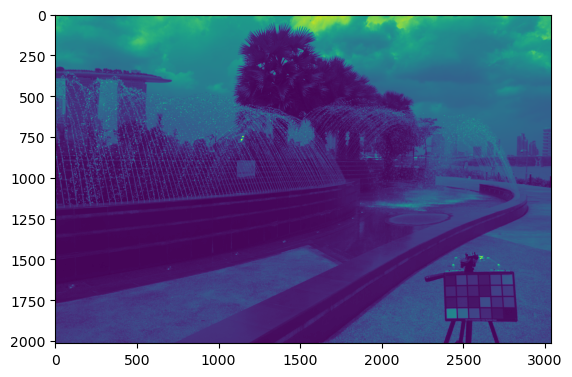

In [4]:
## Print the image
plt.imshow(image )
plt.show()

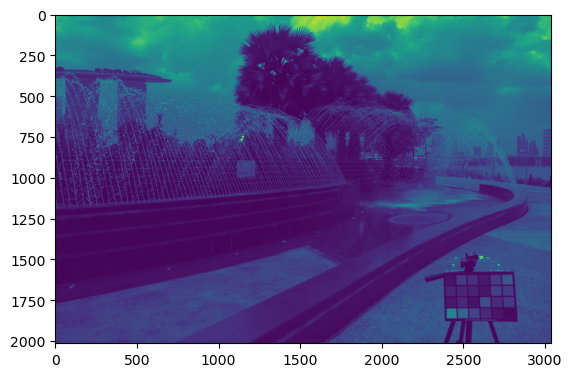

In [5]:
## Convert the image into a double-precision array.
image_double = image.astype(np.double)
plt.imshow(image_double )

In [6]:
print(image_double) #farkını merak ettim
print(image_double.ndim)

[[2443. 3251. 2489. ... 2679. 3565. 2728.]
 [3332. 1487. 3359. ... 3706. 1644. 3607.]
 [2513. 3345. 2524. ... 2655. 3677. 2667.]
 ...
 [ 840.  349.  786. ...  988.  546. 1220.]
 [ 508.  846.  546. ...  619. 1040.  728.]
 [ 760.  385.  937. ... 1148.  514. 1164.]]
2


### 1.3. Linearization (5 points)

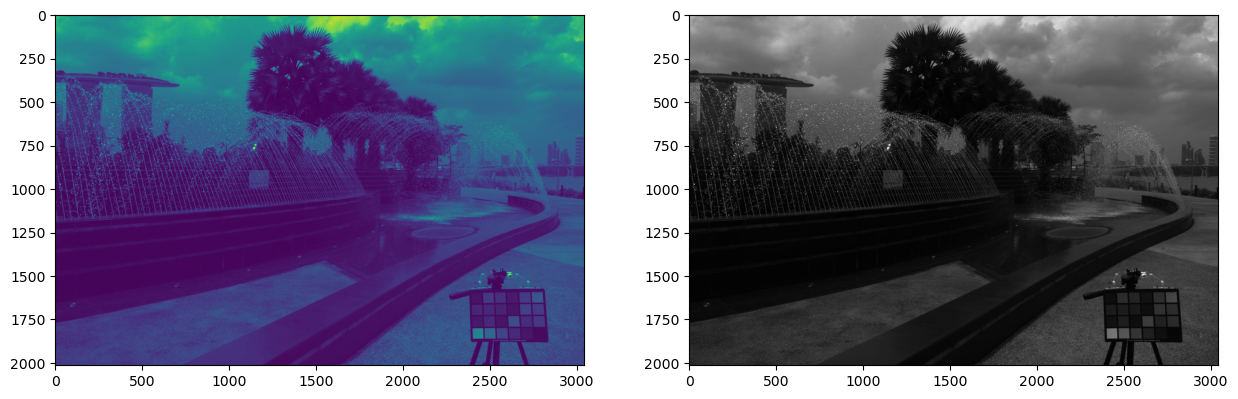

In [7]:
## Apply a linear transformation so that the value <black> is mapped to 0 and <white> to 1. Then, clip negative values to 0
## and values greater than 1 to 1. (See numpy function clip.)
## ( <black> and <white> values are obtained in the first step, raw image conversion ).


#linear transformation
image_linear = (image_double - black) / (white - black)

# [0,1] range
image_linear = np.clip(image_linear, 0., 1.)

# görüntüle

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image_linear)
axes[1].imshow(image_linear, cmap='gray')
plt.show()

### 1.4. White Balancing (10 points)

#### In the following 3 cells you are asked to implement three different automatic white balancing algorithms. The parameters for these functions are up to you. However, please comment, stating their types and purposes.

In [8]:
## Implement a function for white world assumption automatic white balancing algorithm.

def wb_whiteworld(im, pattern):  
    
    """
     (White-World)

    
    im (numpy.ndarray): Giriş görüntüsü (grayscale Bayer deseni).
    pattern (str): Bayer desen formatı ('grbg', 'gbrg', 'rggb', 'bggr').

   
    numpy.ndarray: Beyaz dengesi uygulanmış görüntü.
    """
    # En parlak nokt
    im_brightness = im[::2,1::2] / 3 + im[::2,::2] / 6 + im[1::2,1::2] / 6 + im[1::2,::2] / 3
    tgt_idx = 2*np.unravel_index(np.argmax(im_brightness), im_brightness.shape)
    tgt_grid = im[tgt_idx[0]:tgt_idx[0]+2,tgt_idx[1]:tgt_idx[1]+2]

    if pattern=='grbg':
        red_val = tgt_grid[0,1]
        green_val = (tgt_grid[0,0] + tgt_grid[1,1]) / 2
        blue_val = tgt_grid[1,0]
        im[::2,1::2] = im[::2,1::2] / red_val
        im[::2,::2] = im[::2,::2] / green_val
        im[1::2,1::2] = im[1::2,1::2] / green_val
        im[1::2,::2] = im[1::2,::2] / blue_val

        im = im / np.max(im)

    elif pattern=='gbrg':
        red_val = tgt_grid[1,0]
        green_val = (tgt_grid[0,0] + tgt_grid[1,1]) / 2
        blue_val = tgt_grid[0,1]
        im[::2,1::2] = im[::2,1::2] / blue_val
        im[::2,::2] = im[::2,::2] / green_val
        im[1::2,1::2] = im[1::2,1::2] / green_val
        im[1::2,::2] = im[1::2,::2] / red_val

        im = im / np.max(im)

    elif pattern=='rggb':
        red_val = tgt_grid[0,0]
        green_val = (tgt_grid[0,1] + tgt_grid[1,0]) / 2
        blue_val = tgt_grid[1,1]

        im[::2,::2] = im[::2,::2] / red_val
        im[::2,1::2] = im[::2,1::2] / green_val
        im[1::2,::2] = im[1::2,::2] / green_val
        im[1::2,1::2] = im[1::2,1::2] / blue_val

        im = im / np.max(im)

    elif pattern=='bggr':
        red_val = tgt_grid[1,1]
        green_val = (tgt_grid[0,1] + tgt_grid[1,0]) / 2
        blue_val = tgt_grid[0,0]

        im[::2,::2] = im[::2,::2] / blue_val
        im[::2,1::2] = im[::2,1::2] / green_val
        im[1::2,::2] = im[1::2,::2] / green_val
        im[1::2,1::2] = im[1::2,1::2] / red_val

        im = im / np.max(im)
     
    else:
        raise NotImplementedError
    
    return im

In [9]:
## Implement a function for grey world assumption automatic white balancing algorithm.

def wb_grayworld(im, pattern):   
    """
    (Gray-World)  
    im (numpy.ndarray): Giriş görüntüsü.
    pattern (str): Bayer desen formatı ('grbg', 'gbrg', 'rggb', 'bggr').    
    numpy.ndarray: Beyaz dengesi uygulanmış görüntü.
    """
    if pattern=='grbg':
        
        red_mean = np.mean(im[::2,1::2]) # Red
        green_mean = (np.mean(im[::2,::2]) + np.mean(im[1::2,1::2])) / 2 # Green
        blue_mean = np.mean(im[1::2,::2]) # Blue

        
        im[::2,1::2] = im[::2,1::2] / red_mean
        im[::2,::2] = im[::2,::2] / green_mean
        im[1::2,1::2] = im[1::2,1::2] / green_mean
        im[1::2,::2] = im[1::2,::2] / blue_mean

        im = im / np.max(im)

    elif pattern=='gbrg':
        
        blue_mean = np.mean(im[::2,1::2]) # Blue
        green_mean = (np.mean(im[::2,::2]) + np.mean(im[1::2,1::2])) / 2 # Green
        red_mean = np.mean(im[1::2,::2]) # Red
        
        im[::2,1::2] = im[::2,1::2] / blue_mean
        im[::2,::2] = im[::2,::2] / green_mean
        im[1::2,1::2] = im[1::2,1::2] / green_mean
        im[1::2,::2] = im[1::2,::2] / red_mean

        im = im / np.max(im)

    elif pattern=='rggb':
        
        red_mean = np.mean(im[::2,::2]) # Red
        green_mean = (np.mean(im[::2,1::2]) + np.mean(im[1::2,::2])) / 2 # Green
        blue_mean = np.mean(im[1::2,1::2]) # Blue

        
        im[::2,::2] = im[::2,::2] / red_mean
        im[::2,1::2] = im[::2,1::2] / green_mean
        im[1::2,::2] = im[1::2,::2] / green_mean
        im[1::2,1::2] = im[1::2,1::2] / blue_mean

        im = im / np.max(im)

    elif pattern=='bggr':
        
        blue_mean = np.mean(im[::2,::2]) # Blue
        green_mean = (np.mean(im[::2,1::2]) + np.mean(im[1::2,::2])) / 2 # Green
        red_mean = np.mean(im[1::2,1::2]) # Red

        
        im[::2,::2] = im[::2,::2] / blue_mean
        im[::2,1::2] = im[::2,1::2] / green_mean
        im[1::2,::2] = im[1::2,::2] / green_mean
        im[1::2,1::2] = im[1::2,1::2] / red_mean

        im = im / np.max(im)

    else:
        raise NotImplementedError
    
    return im
    

In [10]:
## Implement a function for a white balancing algorithm, where the red, green, and blue channels are multiplied with
## <r scale>, <g scale>, and <b scale> recorded in the first step, which is the white balancing preset used by the camera.
def wb_rescale(im, pattern, r_scale, g_scale, b_scale):  
    """
    beyaz dengesi 

    im (numpy.ndarray): Giriş görüntüsü.
    pattern (str): Bayer desen formatı ('grbg', 'gbrg', 'rggb', 'bggr')
    r_scale (float): Kırmızı kanal ölçek
    g_scale (float): Yeşil 
    b_scale (float): Mavi 

    numpy.ndarray: Beyaz dengesi uygulanmış görüntü.
    """
    
    if pattern=='grbg':
        # Rescale
        im[::2,1::2] = im[::2,1::2] * r_scale
        im[::2,::2] = im[::2,::2] * g_scale
        im[1::2,1::2] = im[1::2,1::2] * g_scale
        im[1::2,::2] = im[1::2,::2] * b_scale

        im = im / np.max(im)

    elif pattern=='gbrg':
        # Rescale
        im[::2,1::2] = im[::2,1::2] * b_scale
        im[::2,::2] = im[::2,::2] * g_scale
        im[1::2,1::2] = im[1::2,1::2] * g_scale
        im[1::2,::2] = im[1::2,::2] * r_scale

        im = im / np.max(im)

    elif pattern=='rggb':
        # Rescale
        im[::2,::2] = im[::2,::2] * r_scale
        im[::2,1::2] = im[::2,1::2] * g_scale
        im[1::2,::2] = im[1::2,::2] * g_scale
        im[1::2,1::2] = im[1::2,1::2] * b_scale

        im = im / np.max(im)

    elif pattern=='bggr':
        # Rescale
        im[::2,::2] = im[::2,::2] * b_scale
        im[::2,1::2] = im[::2,1::2] * g_scale
        im[1::2,::2] = im[1::2,::2] * g_scale
        im[::2,::2] = im[::2,::2] * r_scale

        im = im / np.max(im)
    else:
        raise NotImplementedError
   
    
    return im

In [11]:
im = image_linear.copy()
h, w = im.shape[:2]#tek sayı hatasını önlemek amacıyla
if h % 2 != 0:
    im = im[:-1, :]
if w % 2 != 0:
    im = im[:, :-1]




In [12]:
im_gw_rggb = wb_grayworld(im, 'rggb')
im_gw_bggr = wb_grayworld(im, 'bggr')
im_ww_rggb = wb_whiteworld(im, 'rggb')
im_ww_bggr = wb_whiteworld(im, 'bggr')
im_rs_rggb = wb_rescale(im, 'rggb', r_scale, g_scale, b_scale)
im_rs_bggr = wb_rescale(im, 'bggr', r_scale, g_scale, b_scale)


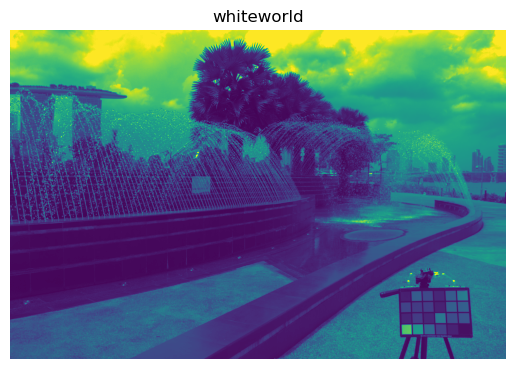

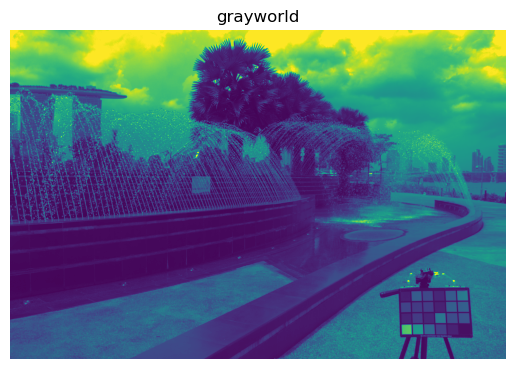

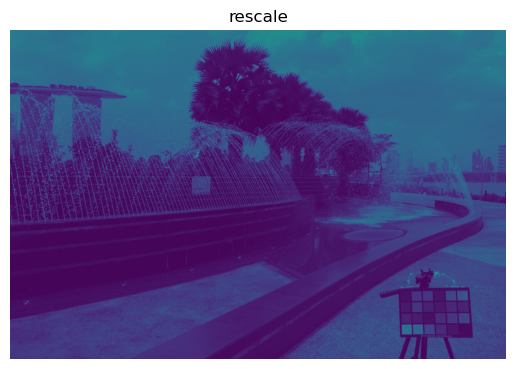

In [13]:

plt.imshow(np.clip((im_ww_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.title("whiteworld")
plt.axis("off")
plt.show()


plt.imshow(np.clip((im_gw_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.title("grayworld")
plt.axis("off")
plt.show()


plt.imshow(np.clip((im_rs_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.title("rescale")
plt.axis("off")
plt.show()

### 1.5. Experiment (possibly with white balancing and/or demosaicing) to identify the correct Bayer Pattern. State which pattern you idenfitied with your logic behind in a seperate markdown cell. (20 points)
#### For demosaicing, apply bilinear interpolation using scipy’s built-in interp2d function.
#### Display each resulting image of your experiments, stating the configuration of the bayyer pattern and the other methods you use, such as WA algorithm.

In [14]:
## Display the resulting images using "each" white balancing algorithm you implemented above.

In [15]:
def demosaic(im, pattern):  
    # meshgrid
    X = np.arange(im.shape[1])
    Y = np.arange(im.shape[0])
    X, Y = np.meshgrid(X, Y, indexing='xy')

    if pattern=='grbg':        
        x = np.arange(1,im.shape[1],2)#red
        y = np.arange(0,im.shape[0],2)
        interp_red = RegularGridInterpolator((y, x), im[::2,1::2], bounds_error=False, fill_value=None)
        im_red = interp_red((Y,X))

        # green
        x = np.arange(0,im.shape[1],2)
        y = np.arange(0,im.shape[0],2)
        interp_green1 = RegularGridInterpolator((y, x), im[::2,::2], bounds_error=False, fill_value=None)
        im_green1 = interp_green1((Y,X))

        x = np.arange(1,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_green2 = RegularGridInterpolator((y, x), im[1::2,1::2], bounds_error=False, fill_value=None)
        im_green2 = interp_green2((Y,X))

        im_green = (im_green1 + im_green2) / 2

        # blue
        x = np.arange(0,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_blue = RegularGridInterpolator((y, x), im[1::2,::2], bounds_error=False, fill_value=None)
        im_blue = interp_blue((Y,X))

    elif pattern=='gbrg':
        #red
        x = np.arange(0,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_red = RegularGridInterpolator((y, x), im[1::2,::2], bounds_error=False, fill_value=None)
        im_red = interp_red((Y,X))

        #g
        x = np.arange(0,im.shape[1],2)
        y = np.arange(0,im.shape[0],2)
        interp_green1 = RegularGridInterpolator((y, x), im[::2,::2], bounds_error=False, fill_value=None)
        im_green1 = interp_green1((Y,X))

        x = np.arange(1,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_green2 = RegularGridInterpolator((y, x), im[1::2,1::2], bounds_error=False, fill_value=None)
        im_green2 = interp_green2((Y,X))

        im_green = (im_green1 + im_green2) / 2

        #b
        x = np.arange(1,im.shape[1],2)
        y = np.arange(0,im.shape[0],2)
        interp_blue = RegularGridInterpolator((y, x), im[::2,1::2], bounds_error=False, fill_value=None)
        im_blue = interp_blue((Y,X))

    elif pattern=='rggb':
        #r
        x = np.arange(0,im.shape[1],2)
        y = np.arange(0,im.shape[0],2)
        interp_red = RegularGridInterpolator((y, x), im[::2,::2], bounds_error=False, fill_value=None)
        im_red = interp_red((Y,X))

        #g
        x = np.arange(0,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_green1 = RegularGridInterpolator((y, x), im[::2,1::2], bounds_error=False, fill_value=None)
        im_green1 = interp_green1((Y,X))

        x = np.arange(1,im.shape[1],2)
        y = np.arange(0,im.shape[0],2)
        interp_green2 = RegularGridInterpolator((y, x), im[1::2,::2], bounds_error=False, fill_value=None)
        im_green2 = interp_green2((Y,X))

        im_green = (im_green1 + im_green2) / 2

        #b
        x = np.arange(1,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_blue = RegularGridInterpolator((y, x), im[1::2,1::2], bounds_error=False, fill_value=None)
        im_blue = interp_blue((Y,X))

    elif pattern=='bggr':
        #r
        x = np.arange(1,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_red = RegularGridInterpolator((y, x), im[1::2,1::2], bounds_error=False, fill_value=None)
        im_red = interp_red((Y,X))

        #g
        x = np.arange(0,im.shape[1],2)
        y = np.arange(1,im.shape[0],2)
        interp_green1 = RegularGridInterpolator((y, x), im[::2,1::2], bounds_error=False, fill_value=None)
        im_green1 = interp_green1((Y,X))

        x = np.arange(1,im.shape[1],2)
        y = np.arange(0,im.shape[0],2)
        interp_green2 = RegularGridInterpolator((y, x), im[1::2,::2], bounds_error=False, fill_value=None)
        im_green2 = interp_green2((Y,X))

        im_green = (im_green1 + im_green2) / 2

        #b
        x = np.arange(0,im.shape[1],2)
        y = np.arange(0,im.shape[0],2)
        interp_blue = RegularGridInterpolator((y, x), im[::2,::2], bounds_error=False, fill_value=None)
        im_blue = interp_blue((Y,X))

    
    
    im_rgb = np.stack([im_red, im_green, im_blue], axis=-1)

    return im_rgb

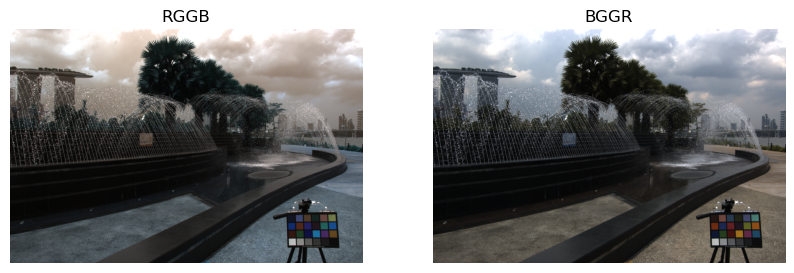

In [16]:


# Demosaicing yapma
im_gw_rggb = demosaic(im_gw_rggb, 'rggb')
im_gw_bggr = demosaic(im_gw_bggr, 'bggr')
im_ww_rggb = demosaic(im_ww_rggb, 'rggb')
im_ww_bggr = demosaic(im_ww_bggr, 'bggr')
im_rs_rggb = demosaic(im_rs_rggb, 'rggb')
im_rs_bggr = demosaic(im_rs_bggr, 'bggr')

# görselleştir rggb ve bggr karar ver
# RGGB Görüntüsü
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.clip((im_ww_rggb * 255 * 3), 0, 255).astype(np.uint8))
plt.title("RGGB")
plt.axis("off")

# BGGR Görüntüsü
plt.subplot(1,2,2)
plt.imshow(np.clip((im_ww_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.title("BGGR")
plt.axis("off")

plt.show()

In [17]:
x=2000
print(im[x:x+2,x:x+2])

[[4.6009322  0.64899921]
 [0.57611228 0.93109609]]


####  [[4.6009322  0.64899921] [0.57611228 0.93109609] . RGGB or BGGR is okay(0.64 and 0.57 close). When we look at the color palettes BGGR is okay.  I choose it. With whiteworld bggr seems okay.]


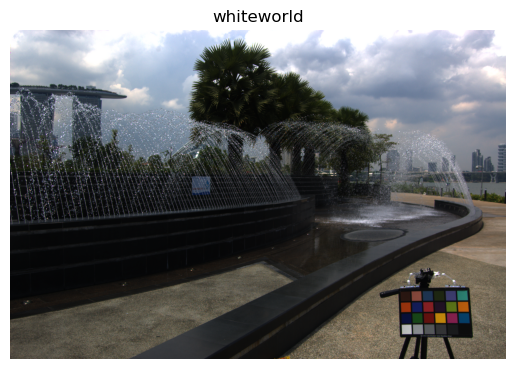

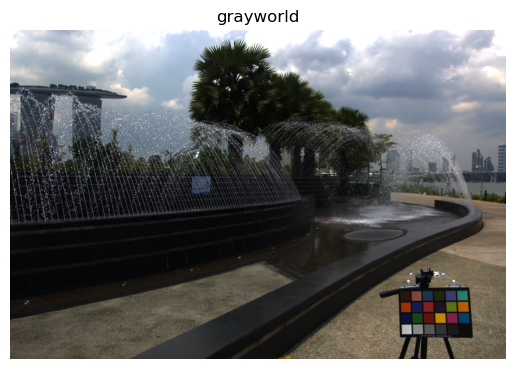

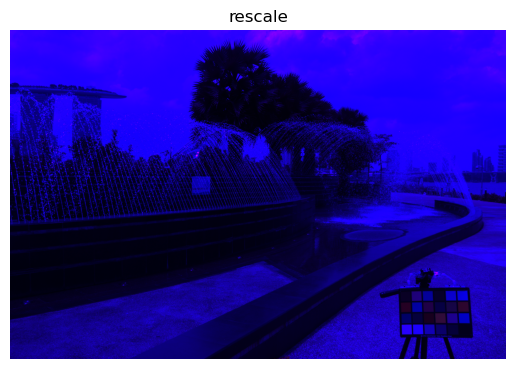

In [36]:
plt.imshow(np.clip((im_ww_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.title("whiteworld")
plt.axis("off")
plt.show()


plt.imshow(np.clip((im_gw_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.title("grayworld")
plt.axis("off")
plt.show()


plt.imshow(np.clip((im_rs_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.title("rescale")
plt.axis("off")
plt.show()

### 1.6. Color space correction. (10 points)
#### Transform your image to the linear sRGB color space. For this, you need to compute $M_{cam\rightarrow sRGB}$ matrix as explained in the homework text.

In [18]:
 M_srgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
                           [0.2126729, 0.7151522, 0.0721750],
                           [0.0193339, 0.1191920, 0.9503041]])
M_xyz2cam = np.array([[6992,-1668,-806],
                          [-8138,15748,2543],
                          [-874,850,7897]]) / 10000
M_srgb2cam = M_xyz2cam @ M_srgb2xyz
M_srgb2cam = M_srgb2cam / np.sum(M_srgb2cam, axis=1, keepdims=True)

im_gw_bggr = (np.linalg.inv(M_srgb2cam) @ im_gw_bggr[:,:,:,None])[:,:,:,0]
im_ww_bggr = (np.linalg.inv(M_srgb2cam) @ im_ww_bggr[:,:,:,None])[:,:,:,0]
im_rs_bggr = (np.linalg.inv(M_srgb2cam) @ im_rs_bggr[:,:,:,None])[:,:,:,0]

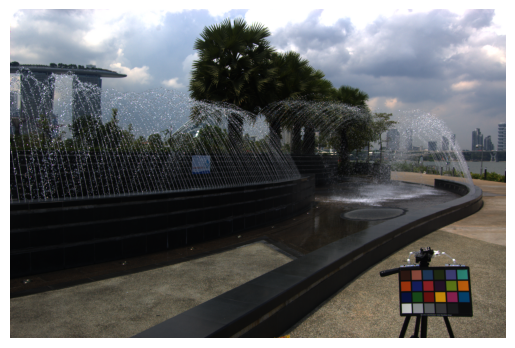

In [19]:

plt.imshow(np.clip((im_ww_bggr * 255 * 3), 0, 255).astype(np.uint8))
plt.axis("off")
plt.show()

### 1.7. Brightness adjustment and gamma encoding. (10 points)

In [20]:
def linear_brightening(im, target_brightness):
    im = im * target_brightness / np.mean(rgb2gray(im))
    im = np.clip(im, 0, 1)

    return im

In [56]:
im_ww_bggr_025 = linear_brightening(im_ww_bggr, 0.1)
im_ww_bggr_050 = linear_brightening(im_ww_bggr, 0.12)
im_ww_bggr_075 = linear_brightening(im_ww_bggr, 0.2)
im_ww_bggr_100 = linear_brightening(im_ww_bggr, 1)

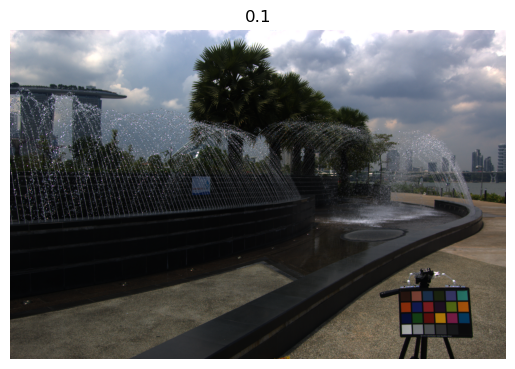

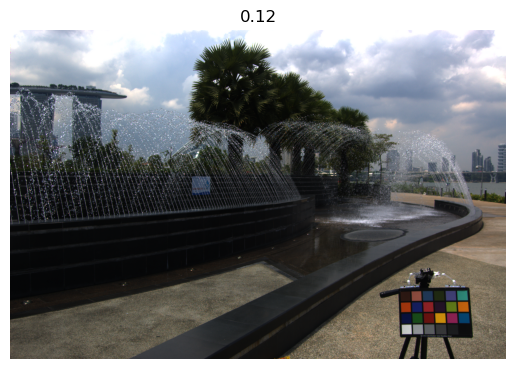

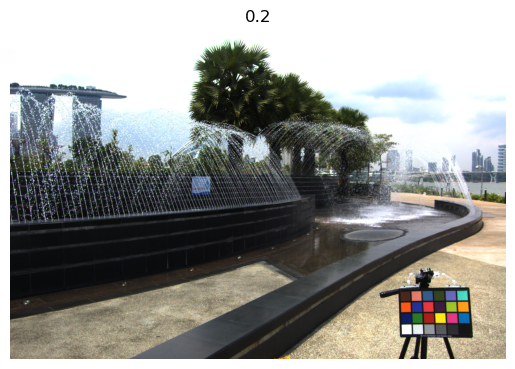

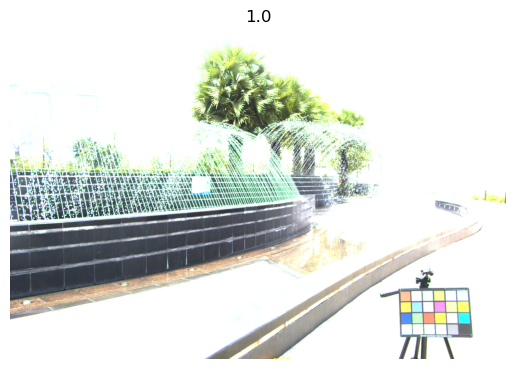

In [57]:
plt.imshow(np.clip((im_ww_bggr_025 * 255 * 3), 0, 255).astype(np.uint8))
plt.title("0.1")
plt.axis("off")
plt.show()


plt.imshow(np.clip((im_ww_bggr_050 * 255 * 3), 0, 255).astype(np.uint8))
plt.title("0.12")
plt.axis("off")
plt.show()


plt.imshow(np.clip((im_ww_bggr_075 * 255 * 3), 0, 255).astype(np.uint8))
plt.title("0.2")
plt.axis("off")
plt.show()

plt.imshow(np.clip((im_ww_bggr_100 * 255 * 3), 0, 255).astype(np.uint8))
plt.title("1.0")
plt.axis("off")
plt.show()


In [58]:
## Experiment with different scaling values in the range [0, 1]. After scaling, clip all intensity values greater than 1 to 1.

#### 0.12 is seems good.

In [59]:
## Apply non-linear gamma encoding
def gamma_encoding(im):
    thresh_mask = (im <= 0.0031308)

    im[thresh_mask] = 12.92 * im[thresh_mask]

    im[np.logical_not(thresh_mask)] = 1.055 * im[np.logical_not(thresh_mask)] ** (1/2.4) - 0.055

    return im

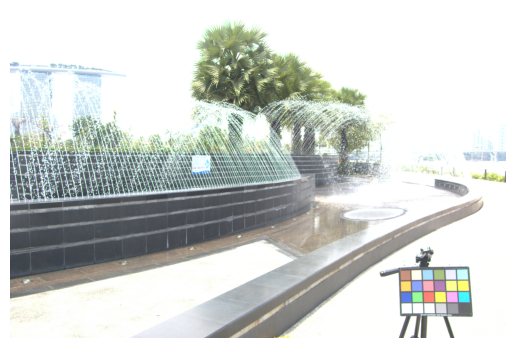

In [60]:
im_ww_bggr_ge = gamma_encoding(im_ww_bggr_050)
plt.imshow(np.clip((im_ww_bggr_ge * 255 * 3), 0, 255).astype(np.uint8))
plt.axis("off")
plt.show()

### 1.8. Compression (5 points)

In [63]:
## Use skimage's imsave function to store the image in .png format (no compression), and also in .jpeg format with the quality
## parameter set to 95
skimage.io.imsave("pngformat.png", np.clip((im_ww_bggr_ge*255).astype(np.uint8), 0, 255))
skimage.io.imsave(f"jpegformat{95}.jpeg", np.clip((im_ww_bggr_ge*255).astype(np.uint8), 0, 255), quality=95)


In [64]:
## Compute the compression ratio
1.34/7.24

0.1850828729281768

#### The lowest quality setting was 70 to me, image looked indistinguishable from the uncompressed image. At 60, I theree some compression artifact. [0.18]s

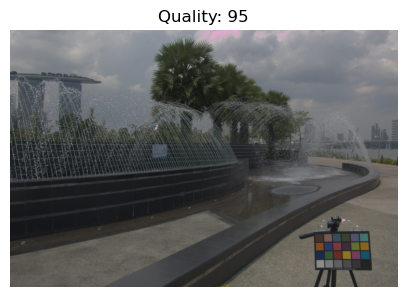

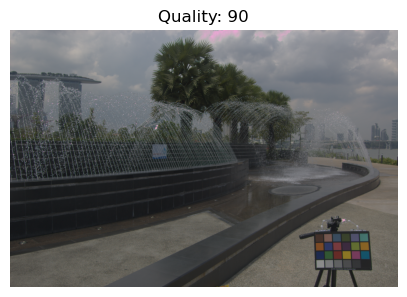

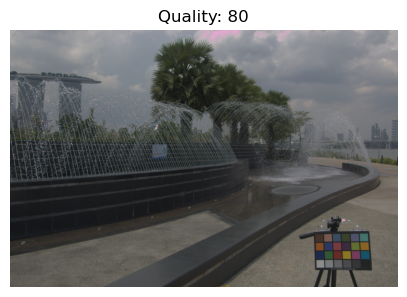

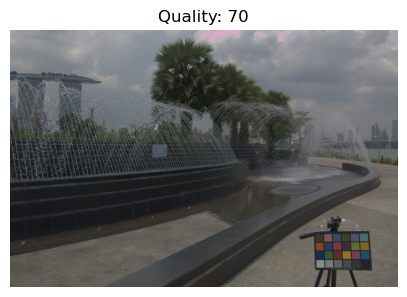

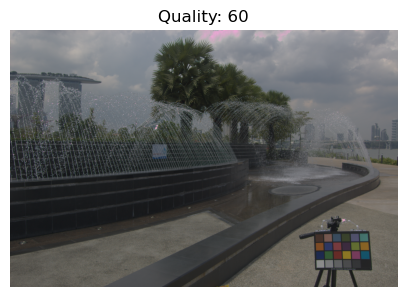

In [67]:
## Show the images with different JPEG quality settings to determine the lowest setting for which the compressed image is
## indistinguishable from the original.
qualities = [95, 90, 80, 70, 60]

for q in qualities:
    filename = f"jpegformat{q}.jpeg"
    img_to_save = np.clip((im_ww_bggr_ge * 255).astype(np.uint8), 0, 255)
    
    # Görüntüyü kaydet
    skimage.io.imsave(filename, img_to_save, quality=q)
    
    # Görüntüyü ekranda göster
    plt.figure(figsize=(5, 5))
    plt.imshow(img_to_save)
    plt.title(f"Quality: {q}")
    plt.axis("off")
    plt.show()

In [66]:
416/7200

0.057777777777777775

#### I said 70 seems okay. And its comparison rating is 0.06

In [26]:
## Select patches in the scene you expect to be white. (Hint: Use ginput)

In [27]:
## Implement the algorithm in the HW text possibly with function(s)

#### Experiment with patch 1

In [28]:
## Normalize all three channels using weights that make the R, G, B channel values of this patch equal

In [29]:
## Show the corresponding resulting image after applying the necessary steps needed to get a properly displayable image.

#### Experiment with patch 2

In [30]:
## Normalize all three channels using weights that make the R, G, B channel values of this patch equal

In [31]:
## Show the corresponding resulting image after applying the necessary steps needed to get a properly displayable image.

## 3. Learn to use dcraw (10 points)

#### Reading the dcraw documentation, report the correct values for flags for the image processing pipeline you have implemented here.

#### You have at least three different images, namely, (1) at least one produced in the image processing pipeline you implemented, (2) produced using dcraw, and (3) image provided in the assignment data folder. Compare, explain the differences among them, and state your favorite one.
* Please add these images here. For this, you can use the following:
```python
from IPython.display import Image
```

In [74]:
imagee1 = skimage.io.imread("sample.ppm")
imagee3 = skimage.io.imread("sample.jpg")


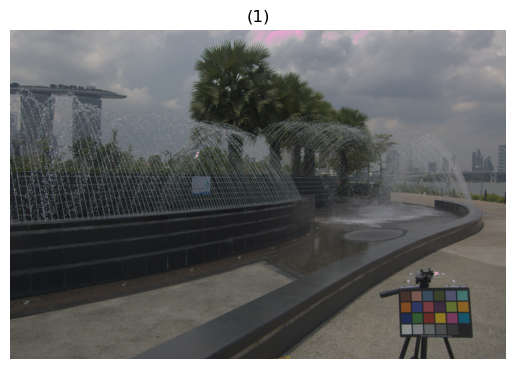

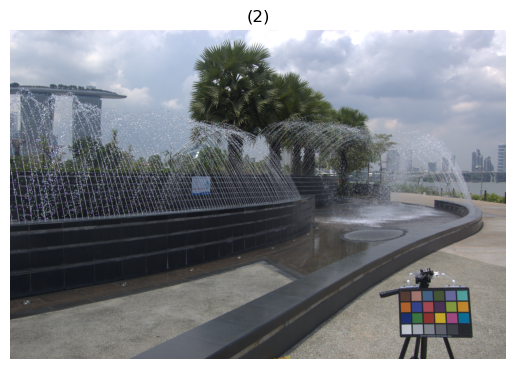

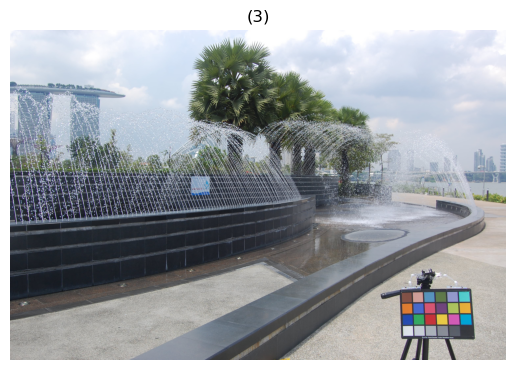

In [76]:
plt.imshow(im_ww_bggr_050)
plt.title("(1)")
plt.axis("off")
plt.show()


plt.imshow(imagee1)
plt.title("(2)")
plt.axis("off")
plt.show()


plt.imshow(imagee3)
plt.title("(3)")
plt.axis("off")
plt.show()

1st one which created in Python  looks washed out.

The second one is seems nice. "dcraw -v -w -o 1 sample.nef" I use this command to make it. It use embedded white balance. -o 1 means Adobe RGB colorspace.

The third one is also seems nice but my choice is first one because of the brightness.
